In [1]:
import os
import random
import logging
from copy import deepcopy
from collections import defaultdict
from matplotlib import pyplot as plt

import cv2
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from albumentations import Compose, Normalize

from isegm.utils.log import logger, TqdmToLogger, SummaryWriterAvg
from isegm.utils.vis import draw_probmap, draw_points, add_tag
from isegm.utils.misc import save_checkpoint
from isegm.utils.serialization import get_config_repr
from isegm.utils.distributed import get_dp_wrapper, get_sampler, reduce_loss_dict
from torch.cuda.amp import autocast as autocast, GradScaler

from isegm.utils.exp_imports.default import *

MODEL_NAME = "lidc_hrnet32"

from isegm.data.compose import ComposeDataset, ProportionalComposeDataset
import torch.nn as nn
from isegm.ritm.utils import vis, exp
cfg = exp.load_config_file('config.yml', return_edict=True)

In [2]:
from isegm.inference import utils
from isegm.data.preprocess import Preprocessor

In [20]:
# DATASET = 'LIDC_2D_FULL_VAL'
DATASET = 'LITS_2D_VAL'
# DATASET = 'MD_PANC_2D_VAL'
preprocessor = Preprocessor()
preprocessor.normalize = False
preprocessor.windowing = False
preprocessor.window_min = -150
preprocessor.window_max = 250
# preprocessor.convert_to_rgb = True

data_set = utils.get_dataset(DATASET, cfg, preprocessor=preprocessor)

In [21]:
loader = DataLoader(
            data_set,
            1,
            sampler=get_sampler(data_set, shuffle=False, distributed=False),
            drop_last=True,
            pin_memory=True,
            num_workers=0,
        )
sample = data_set.get_sample(6)

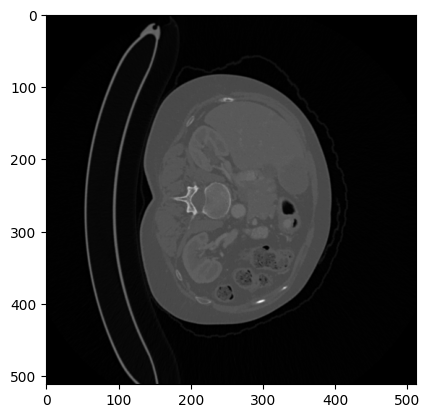

In [22]:
plt.imshow(sample.image[:, :, 0], cmap='gray')

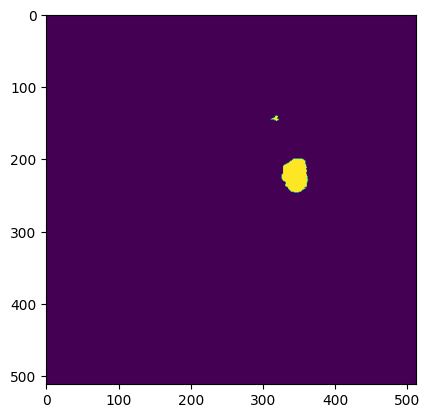

In [23]:
plt.imshow(sample.gt_mask)

In [16]:
plt.hist(sample.flatten(), bins=100)

AttributeError: 'DSample' object has no attribute 'flatten'

In [24]:
def window_and_normalize(img, vmin=-1024, vmax=400):
    img = np.clip(img, vmin, vmax)
    img = img - vmin
    img = img / (vmax - vmin) * 255
    return img

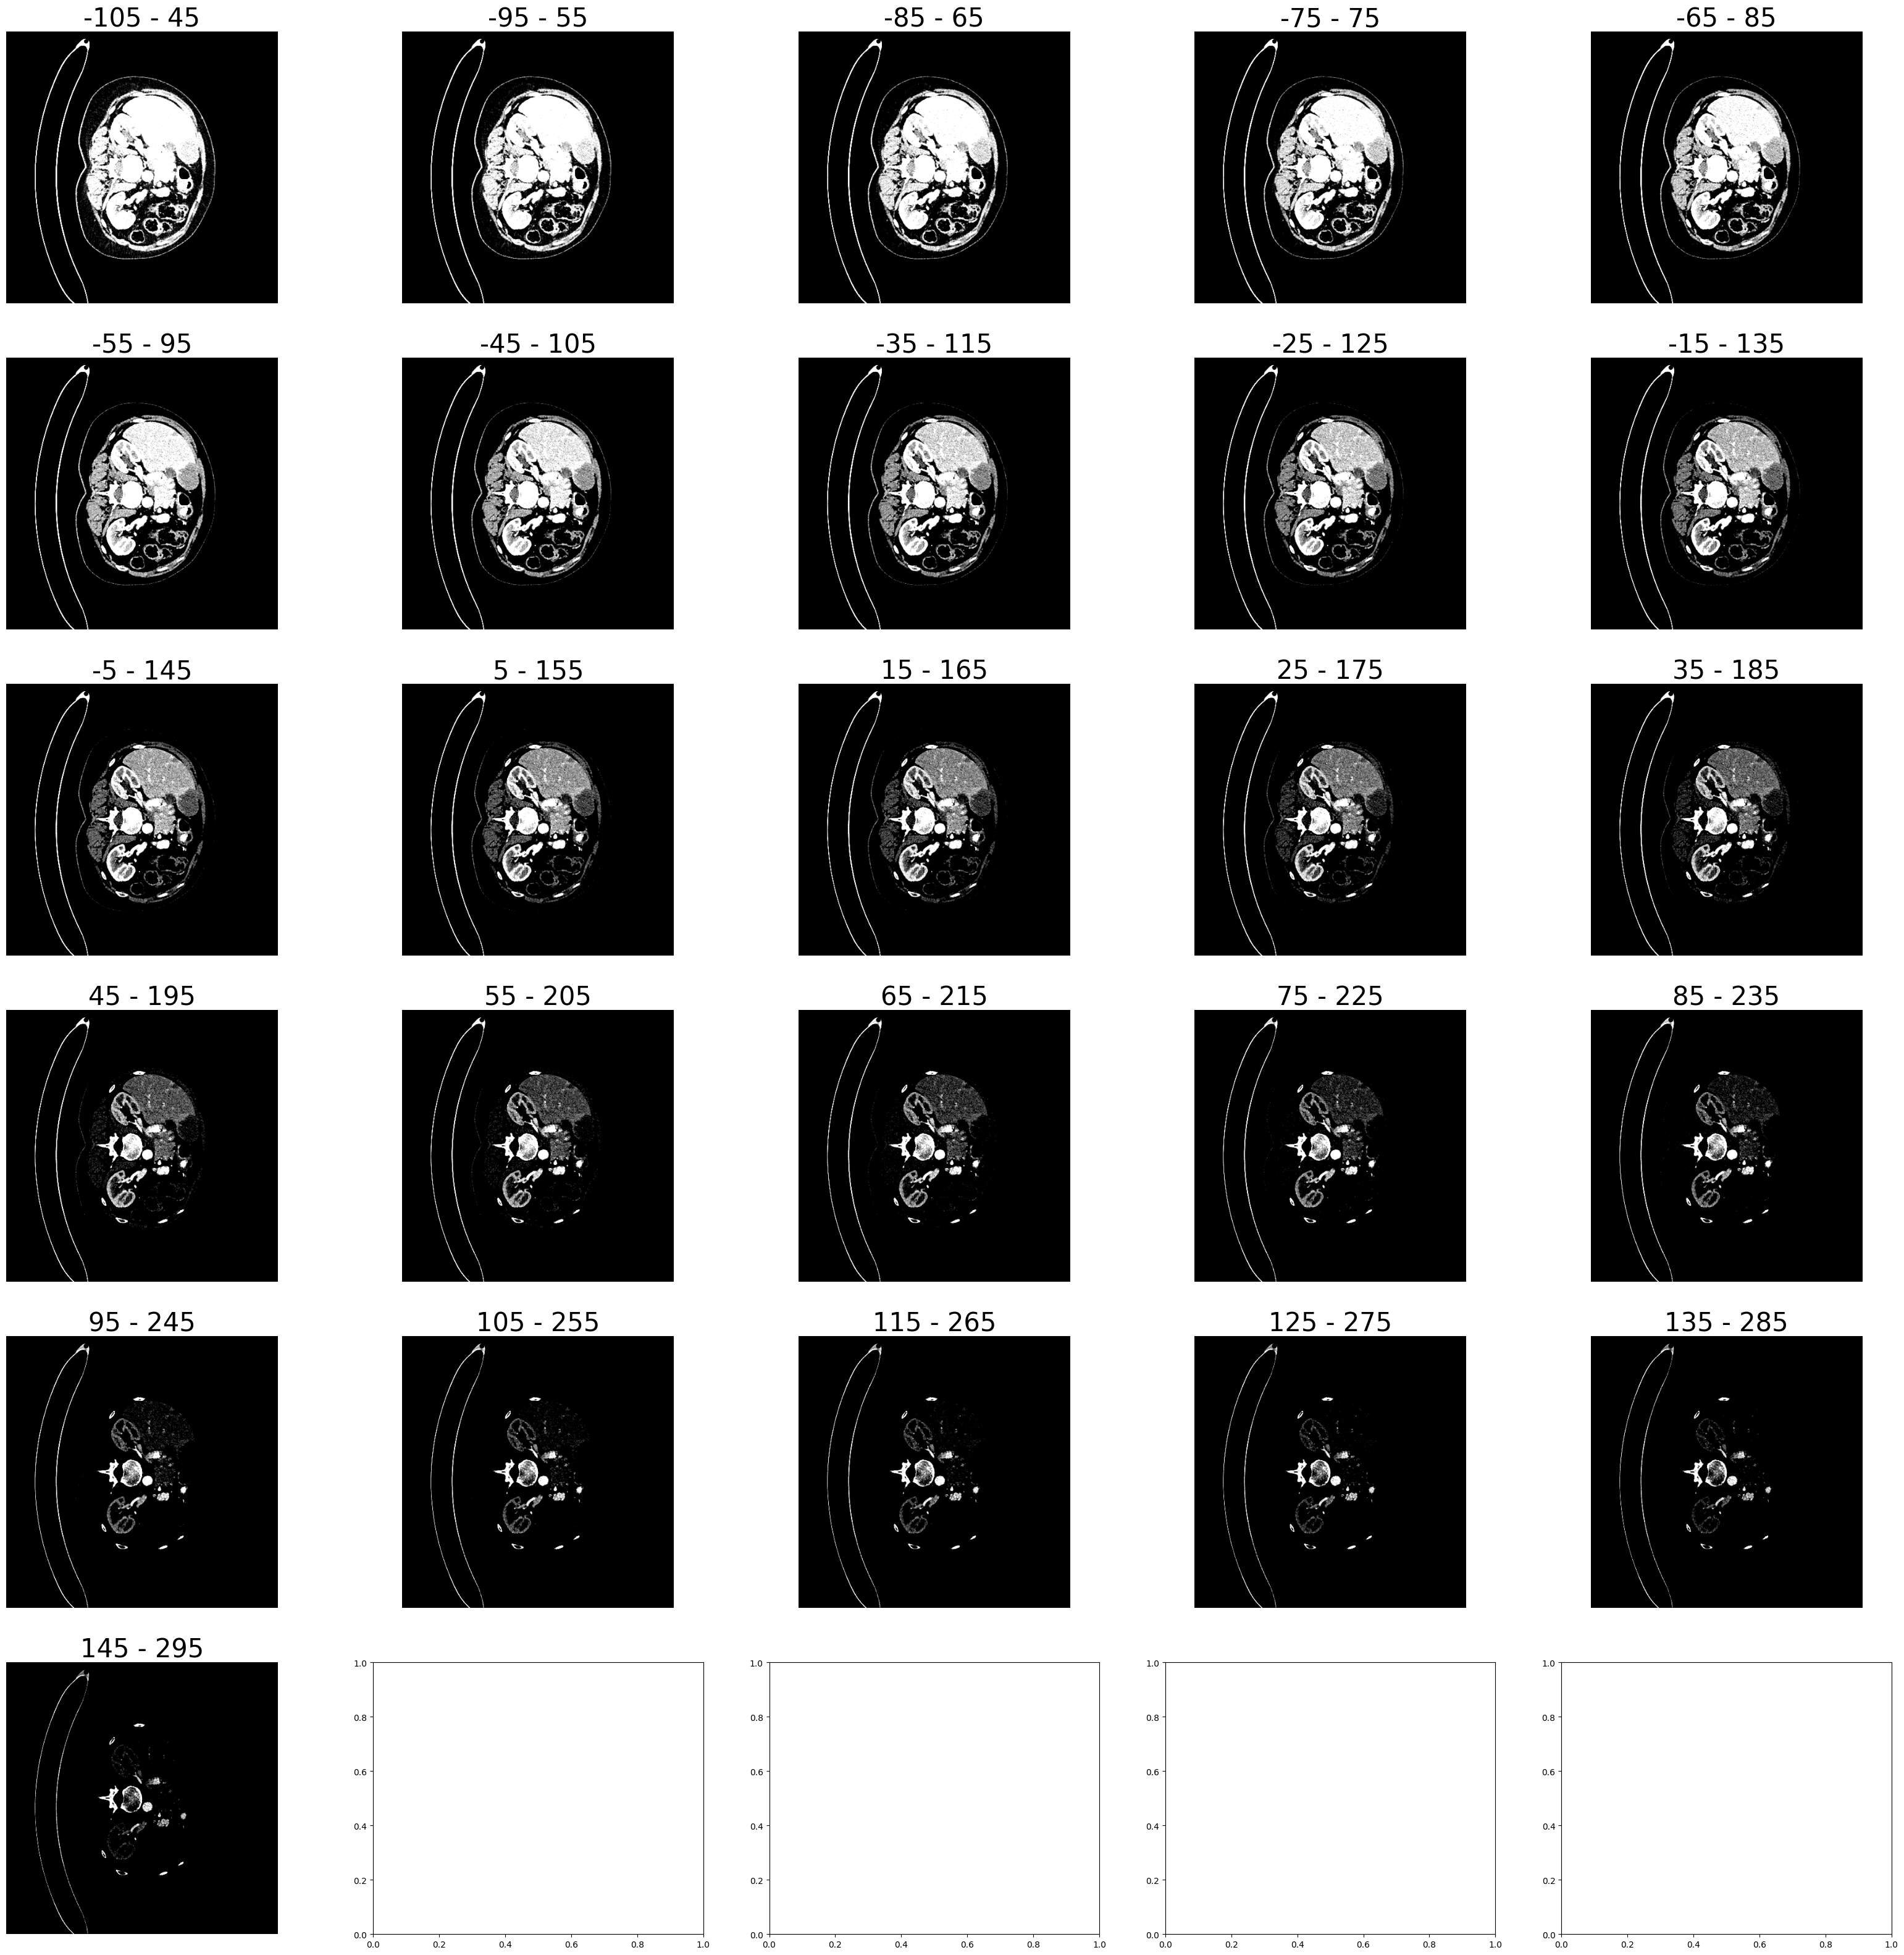

In [26]:
range_min = np.arange(-105, 155, 10)
range_max = range_min + 150

fig, ax = plt.subplots(6, 5, figsize=(40, 40))
for i, (min, max) in enumerate(zip(range_min, range_max)):
    img = window_and_normalize(sample.image[:,:,0], min, max)
    ax[i//5, i%5].imshow(img, cmap='gray')
    ax[i//5, i%5].set_title(f'{min} - {max}', fontsize=30)
    ax[i//5, i%5].axis('off')

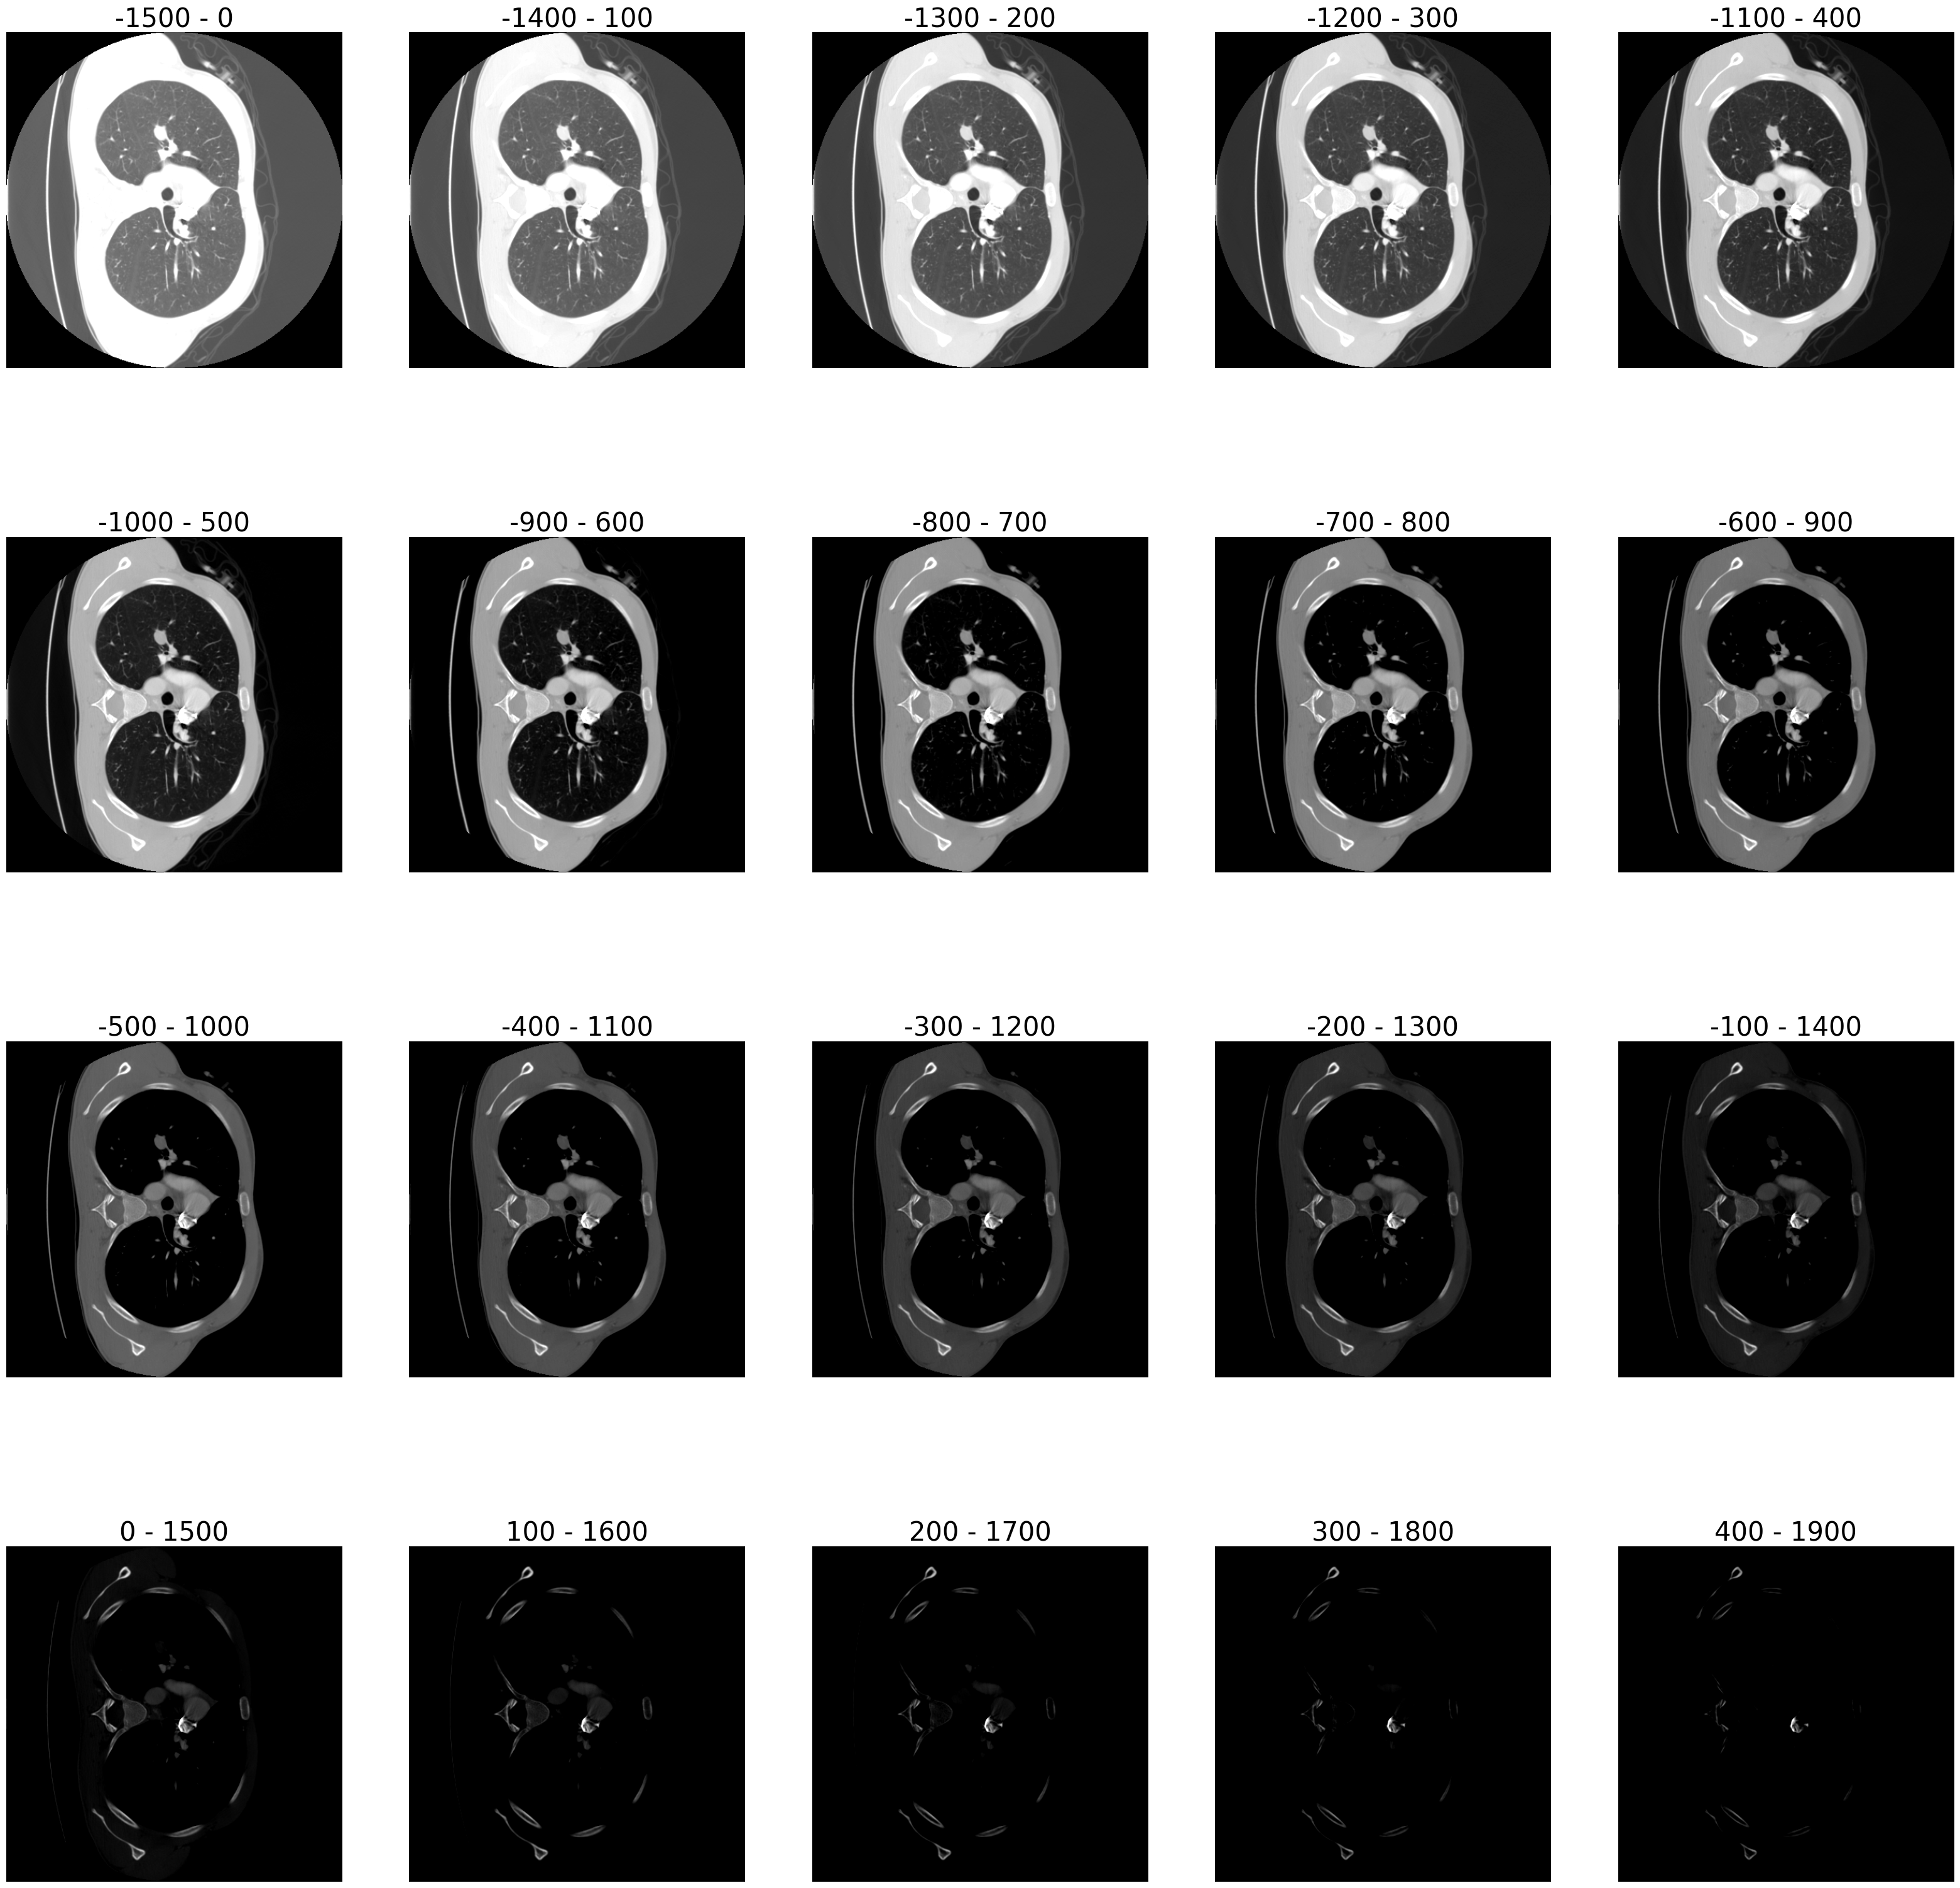

In [ ]:
range_min = np.arange(-1500, 500, 100)
range_max = range_min + 1500

fig, ax = plt.subplots(4, 5, figsize=(40, 40))
for i, (min, max) in enumerate(zip(range_min, range_max)):
    img = np.clip(sample, min, max)
    ax[i//5, i%5].imshow(img, cmap='gray')
    ax[i//5, i%5].set_title(f'{min} - {max}', fontsize=30)
    ax[i//5, i%5].axis('off')